In [1]:
from __future__ import print_function

import sys

sys.path.extend(['/home/jorg/repository/dcnn_acdc'])

import matplotlib
import matplotlib.pyplot as plt

from matplotlib import cm

from datetime import datetime
from pytz import timezone
import copy

import numpy as np
import torch

import numpy as np
import dill
import os
import glob
from collections import OrderedDict

from in_out.load_data import ACDC2017DataSet
from in_out.detector.detector_dataset import RegionDetectorDataSet
from config.config import config
from common.detector.config import config_detector
from plotting.color_maps import transparent_cmap
from utils.exper_hdl_ensemble import ExperHandlerEnsemble
from common.dslices.config import config
from common.detector.box_utils import find_bbox_object, BoundingBox
from utils.detector.batch_handler import BatchHandler
from utils.detector.experiment import Experiment
from utils.detector.exper_handler import ExperimentHandler

mycmap = transparent_cmap(plt.get_cmap('jet'))

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# Constants aka fixed variables
ROOT_DIR = "/home/jorg/repository/dcnn_acdc"

# set seeds
SEED = 4325
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.enabled = True
torch.backends.cudnn.deterministic = True
np.random.seed(SEED)

# Load our baseline 
seg_exper_ensemble = ExperHandlerEnsemble(config.exper_dict_brier)

Load experiment from /home/jorg/repository/dcnn_acdc/logs/20180418_15_02_05_dcnn_mcv1_150000E_lr2e02/stats/exper_stats.dll
INFO - Experimental details extracted:: dcnn_mc p=0.10 fold=['0'] loss=brier
Load experiment from /home/jorg/repository/dcnn_acdc/logs/20180426_14_13_46_dcnn_mc_f1p01_brier_150KE_lr2e02/stats/exper_stats.dll
INFO - Experimental details extracted:: dcnn_mc p=0.10 fold=['1'] loss=brier
Load experiment from /home/jorg/repository/dcnn_acdc/logs/20180426_14_14_39_dcnn_mc_f2p01_brier_150KE_lr2e02/stats/exper_stats.dll
INFO - Experimental details extracted:: dcnn_mc p=0.10 fold=['2'] loss=brier
Load experiment from /home/jorg/repository/dcnn_acdc/logs/20180426_14_14_57_dcnn_mc_f3p01_brier_150KE_lr2e02/stats/exper_stats.dll
INFO - Experimental details extracted:: dcnn_mc p=0.10 fold=['3'] loss=brier


In [3]:
from in_out.detector.detector_dataset import create_dataset

dataset = create_dataset(seg_exper_ensemble, train_fold_id=0, quick_run=False, num_of_input_chnls=3)

INFO - Preparing experimental handlers. This may take a while. Be patient...
INFO - Ready. Loop through patient ids.


100%|██████████| 100/100 [00:33<00:00,  3.03it/s]


In [92]:
print(len(dataset.test_images), dataset.size_test)

78 168


In [87]:
batch_size = 8
new_batch = BatchHandler(dataset, is_train=False, cuda=True, keep_bounding_boxes=False, verbose=False)


In [89]:
for batch_imgs, target_labels_per_roi in new_batch(batch_size=8, keep_batch=True):
    print(new_batch.current_slice_ids)


[8]
[8, 9]
[8, 9, 10]
[8, 9, 10, 11]
[8, 9, 10, 11, 12]
[8, 9, 10, 11, 12, 13]
[8, 9, 10, 11, 12, 13, 14]
[8, 9, 10, 11, 12, 13, 14, 15]


In [ ]:
idx = None
for s in np.arange(len(dataset.test_labels)):
    img = dataset.test_labels[s]
    if 0 != np.count_nonzero(img):
        idx = s
    
        if idx > 25:
            break
    
idx = 133
test_img = dataset.test_images[idx]
test_lbl = dataset.test_labels[idx]
test_pred_roi = dataset.test_pred_lbl_rois[idx]
print(test_img.shape, test_lbl.shape)
print(test_pred_roi)

fig = plt.figure(figsize=(56, 50))
ax1 = plt.subplot2grid((2, 4), (0, 0), rowspan=2, colspan=2)
ax1.imshow(test_img[0], cmap=cm.gray)
ax1.imshow(test_img[2], cmap=mycmap)
# ax1.imshow(test_lbl, cmap=mycmap)
# ax1.imshow(test_img[1], cmap=mycmap)
roi_box = BoundingBox.create(test_pred_roi, padding=0)
print(roi_box.width, roi_box.height)
ax1.add_patch(roi_box.get_matplotlib_patch(color='b'))

plt.axis("off")
plt.show()
# ax2 = plt.subplot2grid((2, 4), (0, 2), rowspan=2, colspan=2)
# ax2.imshow(test_lbl, cmap=cm.gray)
# plt.axis("off")

[ 150.   74.  222.  146.]


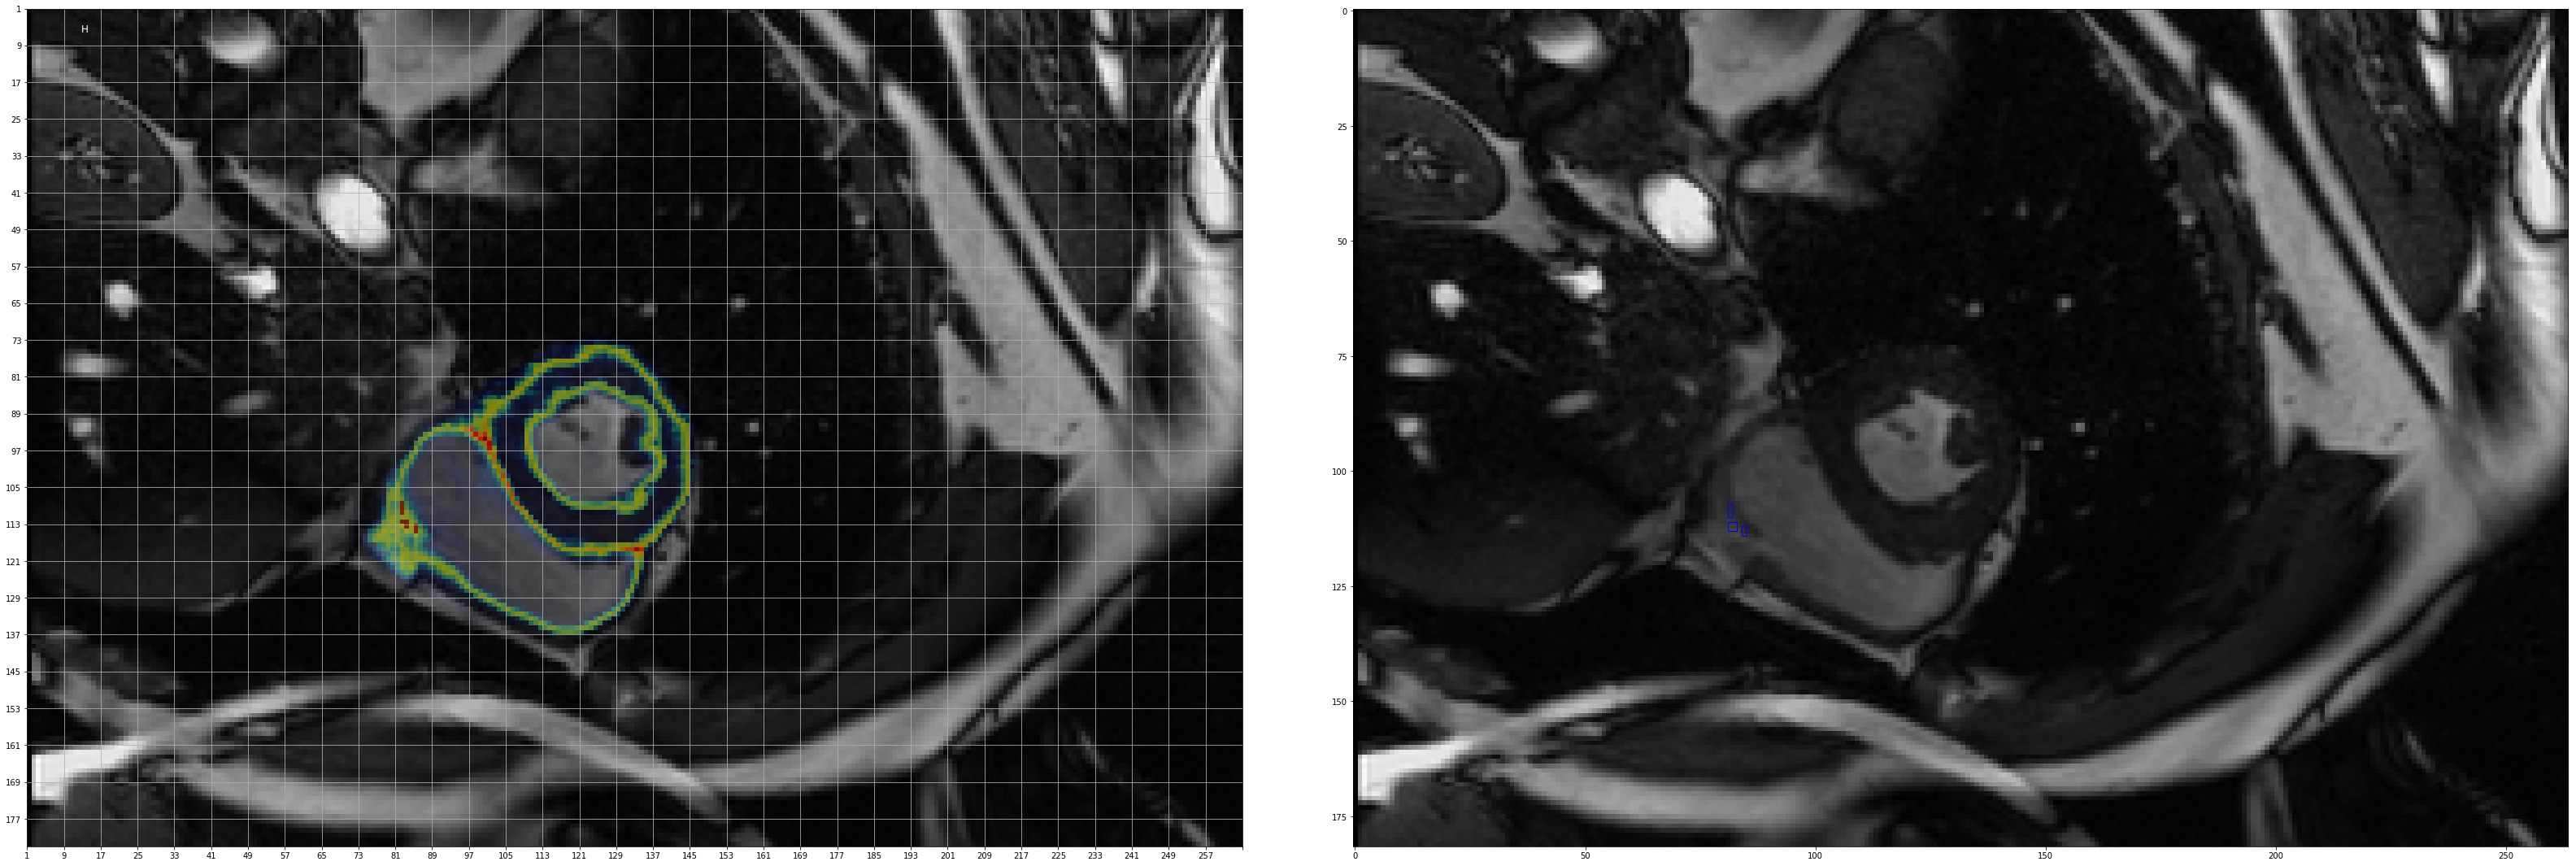

In [68]:
slice_num = 197
batch_nr = 1
image = dataset.train_images[slice_num]
label = dataset.train_labels[slice_num]
bbox = new_batch.batch_bounding_boxes[batch_nr]
bbox = BoundingBox.create(bbox)
print(bbox.box_four)
fig = plt.figure(figsize=(56, 50))

ax1 = plt.subplot2grid((2, 4), (0, 0), rowspan=2, colspan=2)
w, h = image[0].shape
ax1.imshow(image[0], cmap=cm.gray)
ax1.imshow(image[1], cmap=mycmap)
ax1.imshow(label, cmap=mycmap)

ax1.grid(which='minor', color='w', linestyle='-', linewidth=4)
ax1.set_xticks(np.arange(-.5, h, 8))
ax1.set_yticks(np.arange(-.5, w, 8))
ax1.set_xticklabels(np.arange(1, h+1, 8))
ax1.set_yticklabels(np.arange(1, w+1, 8))
ax1.text(12, 4, 'H', size='large',
            ha='center', va='center', color='w')
plt.grid(True)
# ax1.add_patch(bbox.get_matplotlib_patch(color='b'))
ax2 = plt.subplot2grid((2, 4), (0, 2), rowspan=2, colspan=2)
ax2.imshow(image[0], cmap=cm.gray)

for roi_idx in np.arange(dataset.train_lbl_rois[slice_num].shape[0]):
    box_four = dataset.train_lbl_rois[slice_num][roi_idx]
    roi_box = BoundingBox.create(box_four)
    ax2.add_patch(roi_box.get_matplotlib_patch(color='b'))

# ax1.imshow(center_mask, cmap=mycmap)
plt.show()

In [15]:
batch_size = 8
new_batch = BatchHandler(dataset, is_train=True, cuda=True, keep_bounding_boxes=True, verbose=False)
batch_imgs, _target_labels_per_roi = new_batch(batch_size=batch_size)
print(new_batch.current_slice_ids)

[5046, 1807, 1863, 2879, 1572, 815, 4665, 4386]


In [20]:
target_labels = new_batch.target_labels_per_roi
# this is a dict with keys 1, 4, 8
print(np.where(target_labels[8][0] !=0 ))

(array([20, 21, 29, 30, 40, 41, 42, 47, 48, 49, 50, 51, 56, 57, 58, 59, 65,
       66, 67, 68]),)


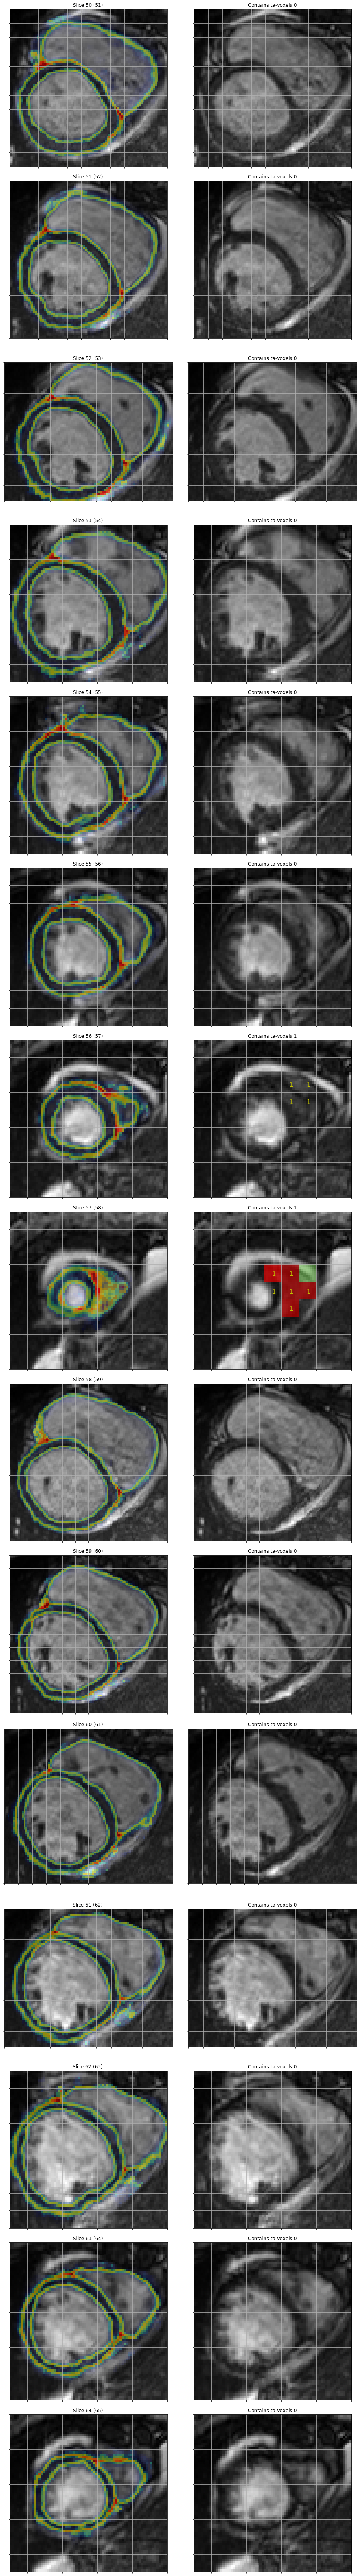

In [32]:
eval_batch.visualize_batch(grid_spacing=8, index_range=[50, 65])

In [4]:
from utils.detector.exper_handler import create_experiment

exper_id = "20181016_11_49_37_rd2_f0p01_brier_emap_200KE_lr1e04"

exp_handler = create_experiment(exper_id)



Load experiment from /home/jorg/repository/dcnn_acdc/logs/RD/20181016_11_49_37_rd2_f0p01_brier_emap_200KE_lr1e04/stats/exper_stats.dll


In [5]:
rd_model = exp_handler.load_checkpoint(checkpoint=150000)

Creating new model RegionDetector: rd2-detector
INFO - RegionDetector - debug - num_of_channels_last_layer 32
INFO - RegionDetector - debug - total #parameters 69956


In [33]:
dataset.get_size(is_train=False)

456

In [34]:
eval_batch = exp_handler.eval(dataset, rd_model, eval_size=500, keep_batch=True, verbose=False)

---> END VALIDATION epoch 200000 #slices=451 (positives=173) loss 0.102: f1=0.267 - roc_auc=0.919 - pr_auc=0.573 - prec=0.322 - rec=0.303 - 1.19 seconds


In [ ]:
import SimpleITK as sitk
arr
img = sitk.GetImageFromArray(arr)
img.SetSpacing(origimg.GetSpacing())
sitk.WriteImage(fname, img)